In [1]:
import pickle
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(19, 11)}, font_scale=2)

# Functions

In [2]:
def get_eval_data_from_path(path, eval_dict, method='baseline'):
    files = sorted(os.listdir(path))
    for query_id in files:
        with open(path + query_id + '/search_output/filenameToScore.json') as f:
            data = json.load(f)
        
        for table in data['scores']:
            eval_dict['query_id'].append(int(query_id[2:]))
            eval_dict['table_id'].append(os.path.splitext(table['tableID'])[0])
            eval_dict['score'].append(table['score'])
            eval_dict['method'].append(method)
            eval_dict['numEntityMappedRows'].append(int(table['numEntityMappedRows']))
            eval_dict['fractionOfEntityMappedRows'].append(float(table['fractionOfEntityMappedRows']))
    
    return eval_dict

In [3]:
def get_emb_comparisons_coverage(path, method, q_id):
    embedding_abs_cos_path = path + "embeddings/abs_cos/single_column_per_entity/"
    embedding_ang_cos_path = path + "embeddings/ang_cos/single_column_per_entity/"
    embedding_norm_cos_path = path + "embeddings/norm_cos/single_column_per_entity/"
    path_choice = ''

    if method == 'embedding_abs_cos':
        path_choice = embedding_abs_cos_path
    elif method == 'embedding_ang_cos':
        path_choice = embedding_ang_cos_path
    elif method == 'embedding_norm_cos':
        path_choice = embedding_norm_cos_path

    with open(path_choice + q_id + '/search_output/filenameToScore.json') as f:
        data = json.load(f)

    embedding_comparisons_coverage = data['numEmbeddingSimComparisons'] / (data['numEmbeddingSimComparisons'] + data['numNonEmbeddingSimComparisons'])

    return embedding_comparisons_coverage

In [4]:
df = pd.read_pickle("query_relevances_cleaned_df.pickle")
df

,query_id,column2,table_id,relevance,num_columns,num_rows,num_numeric_columns
379,8,0,table-1610-48,2.0,3,17,0
380,8,0,table-0145-207,2.0,8,49,0
381,8,0,table-0633-54,1.0,2,11,0
384,8,0,table-0176-187,1.0,8,17,0
385,8,0,table-1389-264,1.0,7,15,0
...,...,...,...,...,...,...,...
3113,60,0,table-0604-492,0.0,9,25,0
3114,60,0,table-0631-704,0.0,5,25,1
3115,60,0,table-0632-243,0.0,5,26,1
3117,60,0,table-0180-80,0.0,5,18,1


# Filtered Tables Evaluation (Old Embedding Scoring)

In [11]:
eval_dict = {'query_id': [], 'table_id': [], 'score': [], 'method': [], 'numEntityMappedRows': [], 'fractionOfEntityMappedRows': []}

baseline_path = "../../search/www18_wikitables_old/baseline/single_column_per_entity/"
embedding_abs_cos_path = "../../search/www18_wikitables_old/embeddings/abs_cos/single_column_per_entity/"
embedding_ang_cos_path = "../../search/www18_wikitables_old/embeddings/ang_cos/single_column_per_entity/"
embedding_norm_cos_path = "../../search/www18_wikitables_old/embeddings/norm_cos/single_column_per_entity/"

# Construct the dataframe
eval_dict = get_eval_data_from_path(path=baseline_path, eval_dict=eval_dict, method='baseline')
eval_dict = get_eval_data_from_path(path=embedding_abs_cos_path, eval_dict=eval_dict, method='embedding_abs_cos')
eval_dict = get_eval_data_from_path(path=embedding_ang_cos_path, eval_dict=eval_dict, method='embedding_ang_cos')
eval_dict = get_eval_data_from_path(path=embedding_norm_cos_path, eval_dict=eval_dict, method='embedding_norm_cos')

eval_df = pd.DataFrame.from_dict(eval_dict)
eval_df

,query_id,table_id,score,method,numEntityMappedRows,fractionOfEntityMappedRows
0,10,table-0623-476,0.5,baseline,29,1.000000
1,10,table-0984-275,0.5,baseline,5,0.142857
2,10,table-1462-369,0.5,baseline,14,0.274510
3,10,table-1384-649,0.5,baseline,46,0.234694
4,10,table-0384-350,0.5,baseline,10,1.000000
...,...,...,...,...,...,...
2103,9,table-1524-764,0.5,embedding_norm_cos,2,0.153846
2104,9,table-0430-782,0.0,embedding_norm_cos,0,0.000000
2105,9,table-0824-357,0.0,embedding_norm_cos,0,0.000000
2106,9,table-0848-924,0.0,embedding_norm_cos,0,0.000000


In [12]:
# Perform NDCG scoring for each query in each method

scores_dict = {'query_id': [], 'method': [], 'ndcg': [], 'num_tables': [], 'avg_num_ent_mapped_rows': [], 'avg_fraction_of_ent_mapped_rows': [], 'embedding_comps_coverage': []}

methods = ['baseline', 'embedding_abs_cos', 'embedding_ang_cos', 'embedding_norm_cos']
for method in methods:
    method_df = eval_df[eval_df['method'] == method]
    q_ids = sorted(method_df['query_id'].unique())
    for q_id in q_ids:
        query_df = method_df[method_df['query_id'] == q_id]
        query_df = query_df.sort_values(by="score", ascending=False)
        query_tables = sorted(query_df['table_id'].unique())

        # Get groundtruth ranking of tables and compute NDCG scores
        gt_df = df[(df['query_id'] == q_id) & (df['table_id'].isin(query_tables))]
        gt_df = gt_df.sort_values(by='relevance', ascending=False)
        
        gt_relevance = np.array([gt_df['relevance'].to_numpy()])
        exp_relevance = []
        for table_id in gt_df['table_id']:
            exp_relevance.append(query_df[query_df['table_id'] == table_id]['score'].values[0])

        score = ndcg_score(gt_relevance, np.array([exp_relevance]), ignore_ties=True)
        
        # Update the scores_dict appropriately
        scores_dict['query_id'].append(q_id)
        scores_dict['method'].append(method)
        scores_dict['ndcg'].append(score)
        scores_dict['num_tables'].append(len(query_tables))

        scores_dict['avg_num_ent_mapped_rows'].append(query_df['numEntityMappedRows'].mean())
        scores_dict['avg_fraction_of_ent_mapped_rows'].append(query_df['fractionOfEntityMappedRows'].mean())

        if method in ['embedding_abs_cos', 'embedding_ang_cos', 'embedding_norm_cos']:
            embs_path = "../../search/www18_wikitables_old/"
            scores_dict['embedding_comps_coverage'].append(get_emb_comparisons_coverage(path=embs_path, method=method, q_id='q_' + str(q_id)))
        else:
            scores_dict['embedding_comps_coverage'].append(np.nan)

scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df

,query_id,method,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
0,8,baseline,0.821904,12,25.333333,0.702666,NaN
1,9,baseline,0.789042,24,12.583333,0.430291,NaN
2,10,baseline,0.660638,23,10.130435,0.407731,NaN
3,15,baseline,0.999798,31,11.387097,0.748704,NaN
4,17,baseline,0.782675,41,24.682927,0.831106,NaN
...,...,...,...,...,...,...,...
79,46,embedding_norm_cos,0.708591,29,24.827586,0.842140,0.026449
80,47,embedding_norm_cos,0.864695,31,22.741935,0.780168,0.855358
81,50,embedding_norm_cos,0.913402,25,29.920000,0.830434,0.427725
82,56,embedding_norm_cos,0.878231,26,18.153846,0.499581,0.314032


In [13]:
scores_df.groupby(['method']).mean()

,query_id,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
method,,,,,,
baseline,29.190476,0.881466,25.095238,20.915447,0.680438,NaN
embedding_abs_cos,29.190476,0.837730,25.095238,20.915447,0.680438,0.460391
embedding_ang_cos,29.190476,0.798910,25.095238,20.915447,0.680438,0.461047
embedding_norm_cos,29.190476,0.811499,25.095238,20.915447,0.680438,0.460971


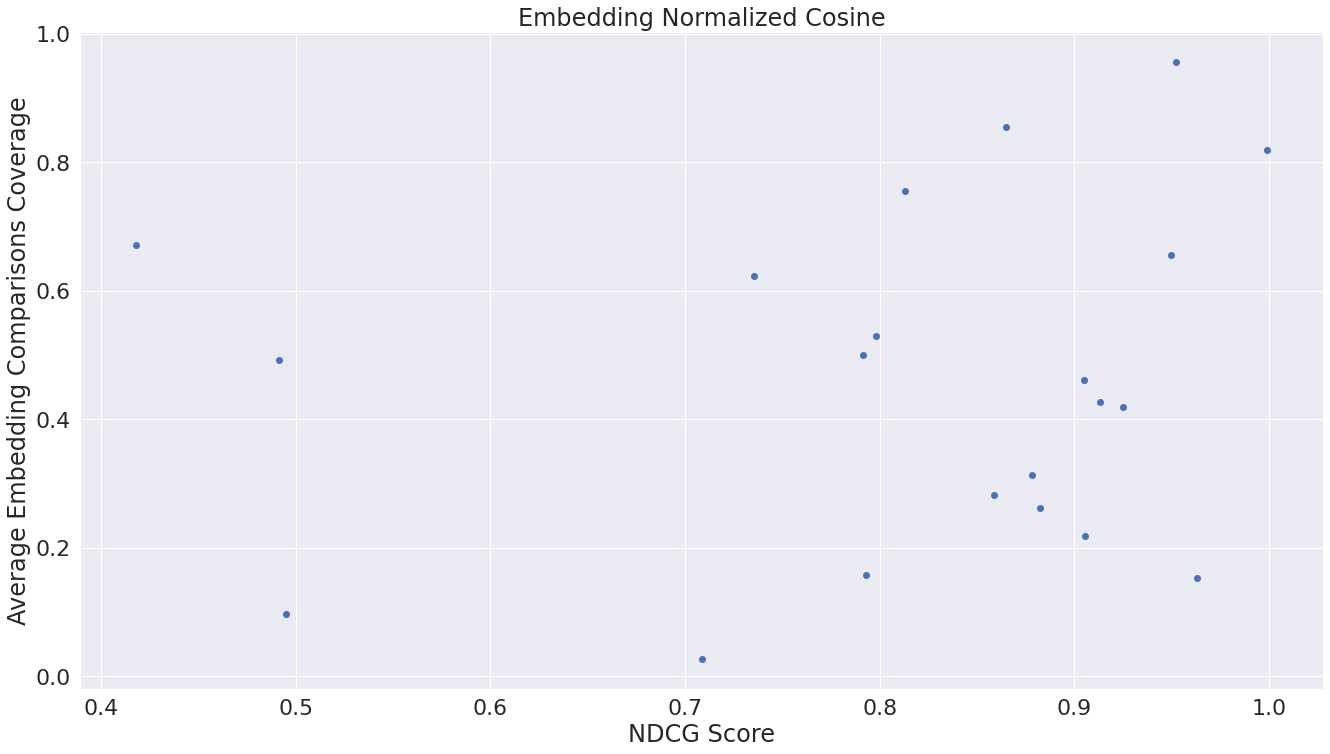

In [14]:
scores_df_norm_cos = scores_df[scores_df['method'] == 'embedding_norm_cos']
plt.scatter(scores_df_norm_cos['ndcg'], scores_df_norm_cos['embedding_comps_coverage'])
plt.xlabel('NDCG Score');plt.ylabel('Average Embedding Comparisons Coverage');plt.title('Embedding Normalized Cosine')
plt.tight_layout()
plt.savefig('ndcg_vs_comp_coverage_norm_cosine.svg')

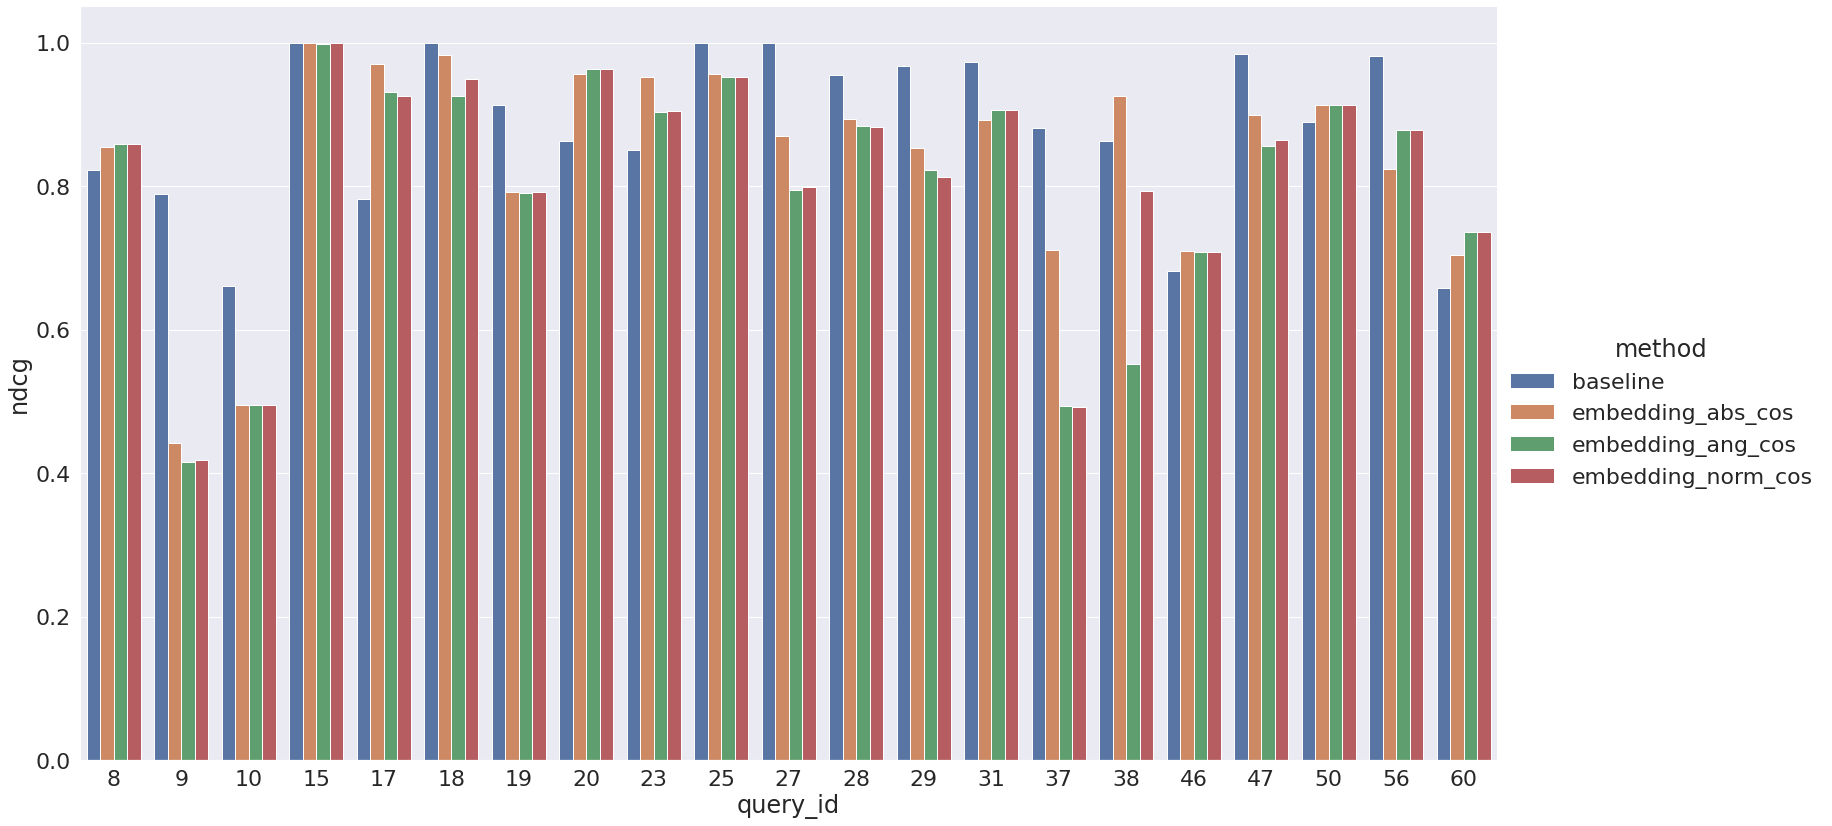

In [15]:
g = sns.catplot(x="query_id", y="ndcg", kind='bar', hue="method", data=scores_df, height=12, aspect=1.8)
# plt.tight_layout()
g.savefig('figures/ndcg_per_query.svg')

In [16]:
better_queries = [9, 17, 20, 23, 46, 50, 60]
scores_df[scores_df['query_id'].isin(better_queries)]

,query_id,method,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
1,9,baseline,0.789042,24,12.583333,0.430291,NaN
4,17,baseline,0.782675,41,24.682927,0.831106,NaN
7,20,baseline,0.863214,28,35.428571,0.820154,NaN
8,23,baseline,0.849656,23,11.000000,0.563753,NaN
16,46,baseline,0.682088,29,24.827586,0.842140,NaN
18,50,baseline,0.888616,25,29.920000,0.830434,NaN
20,60,baseline,0.658192,28,20.785714,0.754025,NaN
22,9,embedding_abs_cos,0.442677,24,12.583333,0.430291,0.675242
25,17,embedding_abs_cos,0.969428,41,24.682927,0.831106,0.416773
28,20,embedding_abs_cos,0.956276,28,35.428571,0.820154,0.153353


In [17]:
scores_df[scores_df['query_id'] == 17]

,query_id,method,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
4,17,baseline,0.782675,41,24.682927,0.831106,NaN
25,17,embedding_abs_cos,0.969428,41,24.682927,0.831106,0.416773
46,17,embedding_ang_cos,0.931353,41,24.682927,0.831106,0.418807
67,17,embedding_norm_cos,0.925004,41,24.682927,0.831106,0.418636


# Filtered Tables Embeddings (New Embedding Scoring, With Missing Query Entities)

In [28]:
eval_dict = {'query_id': [], 'table_id': [], 'score': [], 'method': [], 'numEntityMappedRows': [], 'fractionOfEntityMappedRows': []}

baseline_path = "../../search/www18_wikitables_with_missing_ents/baseline/single_column_per_entity/"
embedding_abs_cos_path = "../../search/www18_wikitables_with_missing_ents/embeddings/abs_cos/single_column_per_entity/"
embedding_ang_cos_path = "../../search/www18_wikitables_with_missing_ents/embeddings/ang_cos/single_column_per_entity/"
embedding_norm_cos_path = "../../search/www18_wikitables_with_missing_ents/embeddings/norm_cos/single_column_per_entity/"

# Construct the dataframe
eval_dict = get_eval_data_from_path(path=baseline_path, eval_dict=eval_dict, method='baseline')
eval_dict = get_eval_data_from_path(path=embedding_abs_cos_path, eval_dict=eval_dict, method='embedding_abs_cos')
eval_dict = get_eval_data_from_path(path=embedding_ang_cos_path, eval_dict=eval_dict, method='embedding_ang_cos')
eval_dict = get_eval_data_from_path(path=embedding_norm_cos_path, eval_dict=eval_dict, method='embedding_norm_cos')

eval_df = pd.DataFrame.from_dict(eval_dict)
eval_df

,query_id,table_id,score,method,numEntityMappedRows,fractionOfEntityMappedRows
0,10,table-0623-476,0.5,baseline,29,1.000000
1,10,table-0984-275,0.5,baseline,5,0.142857
2,10,table-1462-369,0.5,baseline,14,0.274510
3,10,table-1384-649,0.5,baseline,46,0.234694
4,10,table-0384-350,0.5,baseline,10,1.000000
...,...,...,...,...,...,...
2103,9,table-1524-764,0.0,embedding_norm_cos,2,0.153846
2104,9,table-0430-782,0.0,embedding_norm_cos,0,0.000000
2105,9,table-0824-357,0.0,embedding_norm_cos,0,0.000000
2106,9,table-0848-924,0.0,embedding_norm_cos,0,0.000000


In [29]:
# Perform NDCG scoring for each query in each method

scores_dict = {'query_id': [], 'method': [], 'ndcg': [], 'num_tables': [], 'avg_num_ent_mapped_rows': [], 'avg_fraction_of_ent_mapped_rows': [], 'embedding_comps_coverage': []}

methods = ['baseline', 'embedding_abs_cos', 'embedding_ang_cos', 'embedding_norm_cos']
for method in methods:
    method_df = eval_df[eval_df['method'] == method]
    q_ids = sorted(method_df['query_id'].unique())
    for q_id in q_ids:
        query_df = method_df[method_df['query_id'] == q_id]
        query_df = query_df.sort_values(by="score", ascending=False)
        query_tables = sorted(query_df['table_id'].unique())

        # Get groundtruth ranking of tables and compute NDCG scores
        gt_df = df[(df['query_id'] == q_id) & (df['table_id'].isin(query_tables))]
        gt_df = gt_df.sort_values(by='relevance', ascending=False)
        
        gt_relevance = np.array([gt_df['relevance'].to_numpy()])
        exp_relevance = []
        for table_id in gt_df['table_id']:
            exp_relevance.append(query_df[query_df['table_id'] == table_id]['score'].values[0])

        score = ndcg_score(gt_relevance, np.array([exp_relevance]), ignore_ties=True)
        
        # Update the scores_dict appropriately
        scores_dict['query_id'].append(q_id)
        scores_dict['method'].append(method)
        scores_dict['ndcg'].append(score)
        scores_dict['num_tables'].append(len(query_tables))

        scores_dict['avg_num_ent_mapped_rows'].append(query_df['numEntityMappedRows'].mean())
        scores_dict['avg_fraction_of_ent_mapped_rows'].append(query_df['fractionOfEntityMappedRows'].mean())

        if method in ['embedding_abs_cos', 'embedding_ang_cos', 'embedding_norm_cos']:
            embs_path = "../../search/www18_wikitables_with_missing_ents/"
            scores_dict['embedding_comps_coverage'].append(get_emb_comparisons_coverage(path=embs_path, method=method, q_id='q_' + str(q_id)))
        else:
            scores_dict['embedding_comps_coverage'].append(np.nan)

scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df

,query_id,method,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
0,8,baseline,0.821904,12,25.333333,0.702666,NaN
1,9,baseline,0.789042,24,12.583333,0.430291,NaN
2,10,baseline,0.660638,23,10.130435,0.407731,NaN
3,15,baseline,0.999798,31,11.387097,0.748704,NaN
4,17,baseline,0.782675,41,24.682927,0.831106,NaN
...,...,...,...,...,...,...,...
79,46,embedding_norm_cos,0.810373,29,24.827586,0.842140,0.034669
80,47,embedding_norm_cos,0.838625,31,22.741935,0.780168,0.877625
81,50,embedding_norm_cos,0.882680,25,29.920000,0.830434,0.425665
82,56,embedding_norm_cos,0.706941,26,18.153846,0.499581,0.270531


In [30]:
scores_df.groupby(['method']).mean()

,query_id,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
method,,,,,,
baseline,29.190476,0.881466,25.095238,20.915447,0.680438,NaN
embedding_abs_cos,29.190476,0.779456,25.095238,20.915447,0.680438,0.453156
embedding_ang_cos,29.190476,0.767123,25.095238,20.915447,0.680438,0.453216
embedding_norm_cos,29.190476,0.759901,25.095238,20.915447,0.680438,0.453174


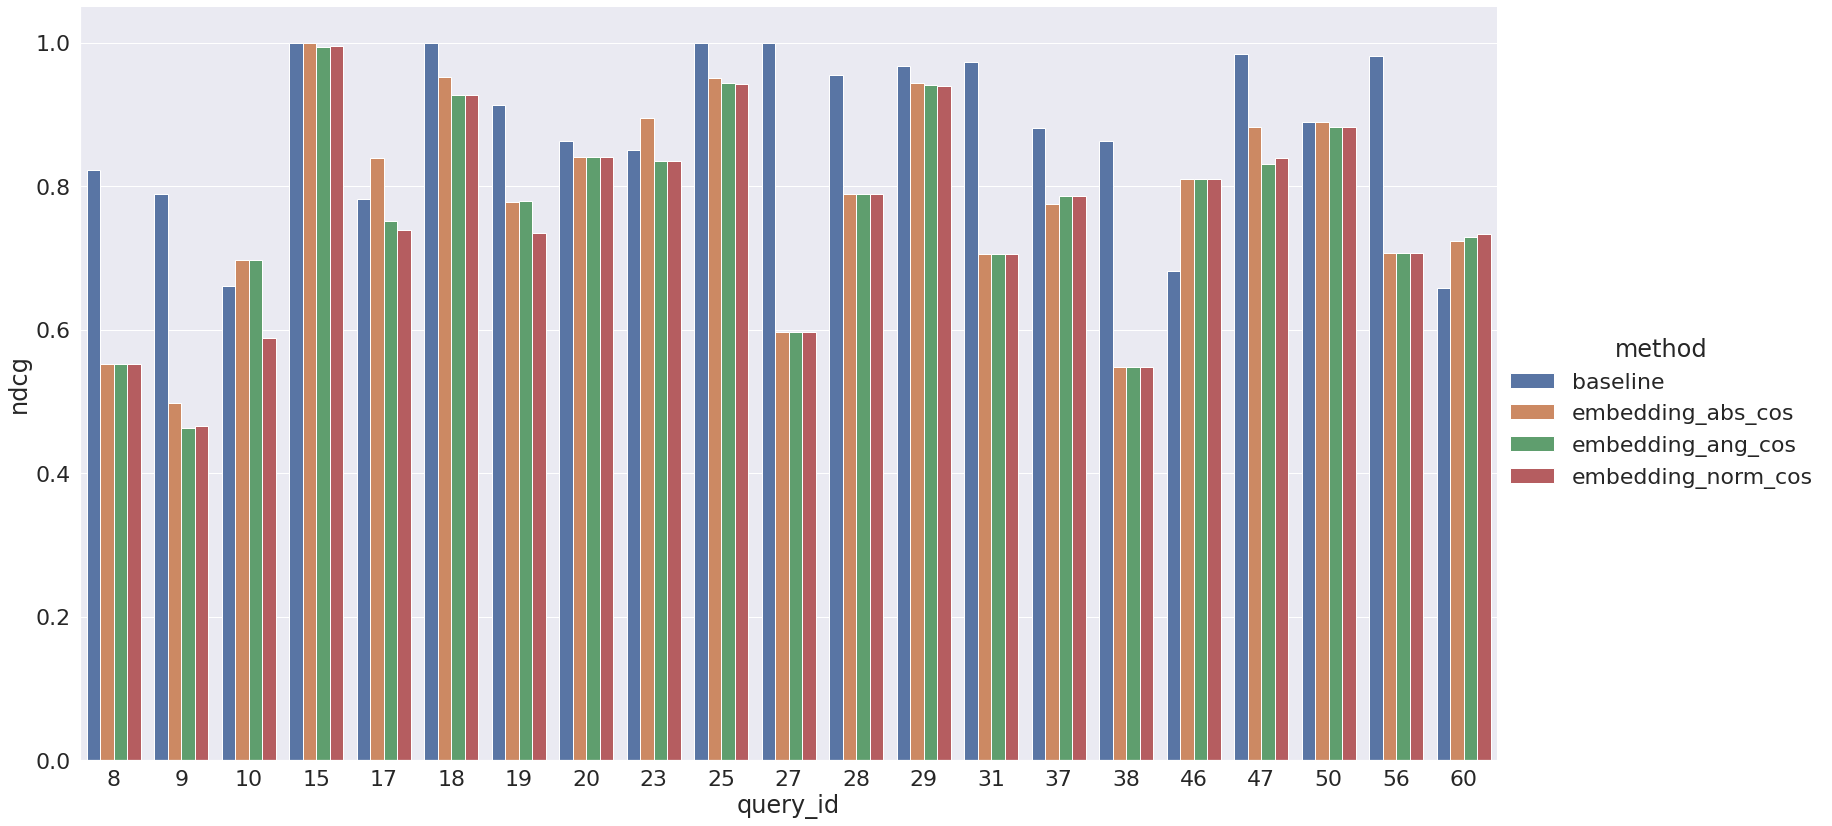

In [31]:
g = sns.catplot(x="query_id", y="ndcg", kind='bar', hue="method", data=scores_df, height=12, aspect=1.8)

In [27]:
# Find the queries where a tuple had missing coverage

path = "../../search/www18_wikitables/embeddings/abs_cos/single_column_per_entity/"
files = sorted(os.listdir(path))
for query_id in files:
    with open(path + query_id + '/search_output/filenameToScore.json') as f:
        data = json.load(f)
    
    print("Query ID:", query_id, "missing query entities:", len(data['queryEntitiesMissingCoverage']))

Query ID: q_10 missing query entities: 14
Query ID: q_15 missing query entities: 1
Query ID: q_17 missing query entities: 31
Query ID: q_18 missing query entities: 4
Query ID: q_19 missing query entities: 4
Query ID: q_20 missing query entities: 1
Query ID: q_23 missing query entities: 7
Query ID: q_25 missing query entities: 2
Query ID: q_27 missing query entities: 2
Query ID: q_28 missing query entities: 1
Query ID: q_29 missing query entities: 5
Query ID: q_31 missing query entities: 3
Query ID: q_37 missing query entities: 7
Query ID: q_38 missing query entities: 4
Query ID: q_46 missing query entities: 23
Query ID: q_47 missing query entities: 0
Query ID: q_50 missing query entities: 4
Query ID: q_56 missing query entities: 4
Query ID: q_60 missing query entities: 0
Query ID: q_8 missing query entities: 1
Query ID: q_9 missing query entities: 0


# Filtered Tables Embeddings (New Embedding Scoring, No Missing Query Entities)

In [21]:
eval_dict = {'query_id': [], 'table_id': [], 'score': [], 'method': [], 'numEntityMappedRows': [], 'fractionOfEntityMappedRows': []}

baseline_path = "../../search/www18_wikitables/baseline/single_column_per_entity/"
embedding_abs_cos_path = "../../search/www18_wikitables/embeddings/abs_cos/single_column_per_entity/"
embedding_ang_cos_path = "../../search/www18_wikitables/embeddings/ang_cos/single_column_per_entity/"
embedding_norm_cos_path = "../../search/www18_wikitables/embeddings/norm_cos/single_column_per_entity/"

# Construct the dataframe
eval_dict = get_eval_data_from_path(path=baseline_path, eval_dict=eval_dict, method='baseline')
eval_dict = get_eval_data_from_path(path=embedding_abs_cos_path, eval_dict=eval_dict, method='embedding_abs_cos')
eval_dict = get_eval_data_from_path(path=embedding_ang_cos_path, eval_dict=eval_dict, method='embedding_ang_cos')
eval_dict = get_eval_data_from_path(path=embedding_norm_cos_path, eval_dict=eval_dict, method='embedding_norm_cos')

eval_df = pd.DataFrame.from_dict(eval_dict)
eval_df

,query_id,table_id,score,method,numEntityMappedRows,fractionOfEntityMappedRows
0,10,table-0623-476,0.5,baseline,29,1.000000
1,10,table-0984-275,0.5,baseline,5,0.142857
2,10,table-1462-369,0.5,baseline,14,0.274510
3,10,table-1384-649,0.5,baseline,46,0.234694
4,10,table-0384-350,0.5,baseline,10,1.000000
...,...,...,...,...,...,...
2103,9,table-1524-764,0.0,embedding_norm_cos,2,0.153846
2104,9,table-0430-782,0.0,embedding_norm_cos,0,0.000000
2105,9,table-0824-357,0.0,embedding_norm_cos,0,0.000000
2106,9,table-0848-924,0.0,embedding_norm_cos,0,0.000000


In [22]:
# Perform NDCG scoring for each query in each method

scores_dict = {'query_id': [], 'method': [], 'ndcg': [], 'num_tables': [], 'avg_num_ent_mapped_rows': [], 'avg_fraction_of_ent_mapped_rows': [], 'embedding_comps_coverage': []}

methods = ['baseline', 'embedding_abs_cos', 'embedding_ang_cos', 'embedding_norm_cos']
for method in methods:
    method_df = eval_df[eval_df['method'] == method]
    q_ids = sorted(method_df['query_id'].unique())
    for q_id in q_ids:
        query_df = method_df[method_df['query_id'] == q_id]
        query_df = query_df.sort_values(by="score", ascending=False)
        query_tables = sorted(query_df['table_id'].unique())

        # Get groundtruth ranking of tables and compute NDCG scores
        gt_df = df[(df['query_id'] == q_id) & (df['table_id'].isin(query_tables))]
        gt_df = gt_df.sort_values(by='relevance', ascending=False)
        
        gt_relevance = np.array([gt_df['relevance'].to_numpy()])
        exp_relevance = []
        for table_id in gt_df['table_id']:
            exp_relevance.append(query_df[query_df['table_id'] == table_id]['score'].values[0])

        score = ndcg_score(gt_relevance, np.array([exp_relevance]), ignore_ties=True)
        
        # Update the scores_dict appropriately
        scores_dict['query_id'].append(q_id)
        scores_dict['method'].append(method)
        scores_dict['ndcg'].append(score)
        scores_dict['num_tables'].append(len(query_tables))

        scores_dict['avg_num_ent_mapped_rows'].append(query_df['numEntityMappedRows'].mean())
        scores_dict['avg_fraction_of_ent_mapped_rows'].append(query_df['fractionOfEntityMappedRows'].mean())

        if method in ['embedding_abs_cos', 'embedding_ang_cos', 'embedding_norm_cos']:
            embs_path = "../../search/www18_wikitables/"
            scores_dict['embedding_comps_coverage'].append(get_emb_comparisons_coverage(path=embs_path, method=method, q_id='q_' + str(q_id)))
        else:
            scores_dict['embedding_comps_coverage'].append(np.nan)

scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df

,query_id,method,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
0,8,baseline,0.924775,12,25.333333,0.702666,NaN
1,9,baseline,0.789042,24,12.583333,0.430291,NaN
2,10,baseline,0.660638,23,10.130435,0.407731,NaN
3,15,baseline,0.999798,31,11.387097,0.748704,NaN
4,17,baseline,0.724449,41,24.682927,0.831106,NaN
...,...,...,...,...,...,...,...
79,46,embedding_norm_cos,0.832086,29,24.827586,0.842140,0.611026
80,47,embedding_norm_cos,0.838625,31,22.741935,0.780168,0.877625
81,50,embedding_norm_cos,0.882680,25,29.920000,0.830434,0.509015
82,56,embedding_norm_cos,0.896152,26,18.153846,0.499581,0.664899


In [23]:
scores_df.groupby(['method']).mean()

,query_id,ndcg,num_tables,avg_num_ent_mapped_rows,avg_fraction_of_ent_mapped_rows,embedding_comps_coverage
method,,,,,,
baseline,29.190476,0.862954,25.095238,20.915447,0.680438,NaN
embedding_abs_cos,29.190476,0.854197,25.095238,20.915447,0.680438,0.688310
embedding_ang_cos,29.190476,0.836010,25.095238,20.915447,0.680438,0.688473
embedding_norm_cos,29.190476,0.828983,25.095238,20.915447,0.680438,0.688446


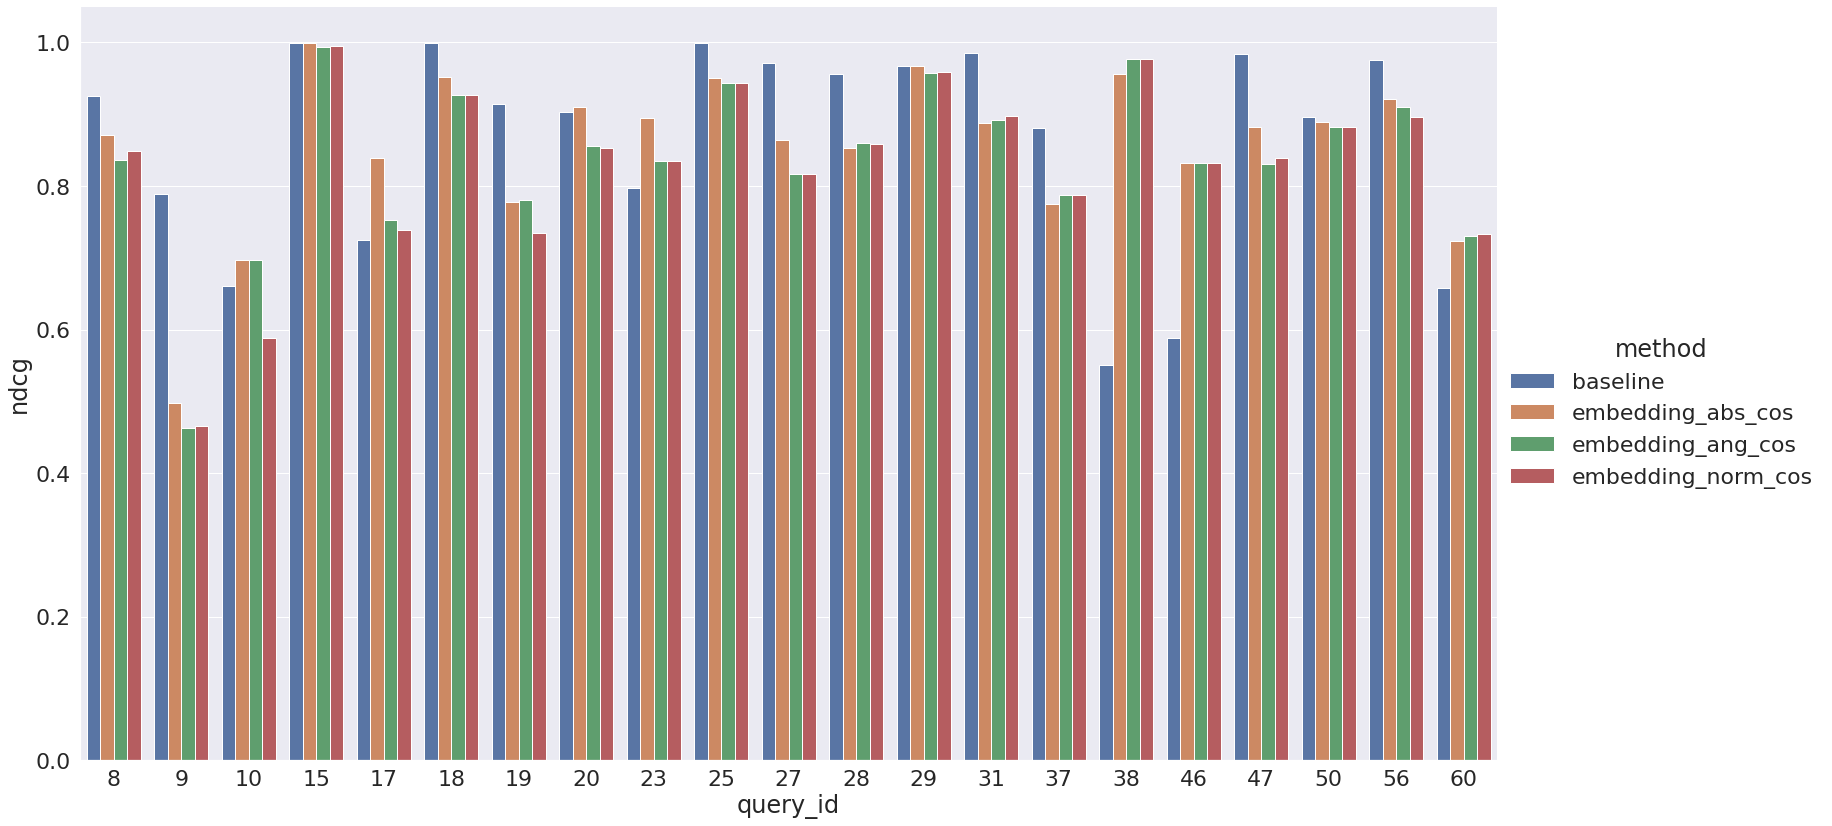

In [25]:
g = sns.catplot(x="query_id", y="ndcg", kind='bar', hue="method", data=scores_df, height=12, aspect=1.8)
plt.savefig('figures/ndcg_per_query_updated_queries.svg')

# PPR Evaluation (Comparison Against Baseline)

In [32]:
def get_queryID_to_tables_dict(path):
    queryID_to_tables_dict = {}
    for query_id in sorted(os.listdir(path)):
        try:
            with open(path + query_id + '/search_output/filenameToScore.json') as f:
                data = json.load(f)
            table_scores_dict = {'tableID': [], 'score': []}
            for table_dict in data['scores']:
                table_scores_dict['tableID'].append(table_dict['tableID'])
                table_scores_dict['score'].append(table_dict['score'])
            queryID_to_tables_dict[query_id] = pd.DataFrame.from_dict(table_scores_dict)
        except:
            print(path + query_id + '/search_output/filenameToScore.json', 'cannot be opened')
    
    return queryID_to_tables_dict

def get_embedding_coverage(path, query):
    with open(path + query + '/search_output/filenameToScore.json') as f:
        data = json.load(f)

    return data['embeddingCoverageSuccessRate']


def get_ndcg_scores(scores_dict, ppr_queryID_to_tables_dict, gt_queryID_to_tables_dict, ground_truth_method, path=None):
    for query in gt_queryID_to_tables_dict:
        query_id = int(query[2:])
        
        gt_df = gt_queryID_to_tables_dict[query]
        ppr_df = ppr_queryID_to_tables_dict[query]
        
        gt_relevance = np.array([gt_df['score'].to_numpy()])
        ppr_relevance = []
        for tableID in gt_df['tableID']:
            ppr_relevance.append(ppr_df[ppr_df['tableID'] == tableID]['score'].values[0])

        score = ndcg_score(gt_relevance, np.array([ppr_relevance]))

        scores_dict['query_id'].append(query_id)
        scores_dict['ndcg'].append(score)
        
        # Extract number of tables retried by PPR for the current query
        scores_dict['num_tables'].append(len(ppr_queryID_to_tables_dict[query].index))

        if ground_truth_method == "embedding":
            # TODO: find the embedding coverage for the current query
            scores_dict['embedding_coverage'].append(get_embedding_coverage(path, query))
        else:
            scores_dict['embedding_coverage'].append(np.nan)
        scores_dict['ground_truth_method'].append(ground_truth_method)

    return scores_dict


def get_ppr_scores_df(ppr_path, ppr_naive_path, ppr_abs_cos_path):

    # Get dictionaries of query_id to dataframe of the tables to scores mappings
    ppr_queryID_to_tables_dict = get_queryID_to_tables_dict(ppr_path)
    naive_queryID_to_tables_dict = get_queryID_to_tables_dict(ppr_naive_path)
    abs_cos_queryID_to_tables_dict = get_queryID_to_tables_dict(ppr_abs_cos_path)

    scores_dict = {'query_id': [], 'ndcg': [], 'num_tables': [], 'embedding_coverage': [], 'ground_truth_method': []}

    scores_dict = get_ndcg_scores(scores_dict, ppr_queryID_to_tables_dict, naive_queryID_to_tables_dict, ground_truth_method="naive")
    scores_dict = get_ndcg_scores(scores_dict, ppr_queryID_to_tables_dict, abs_cos_queryID_to_tables_dict, ground_truth_method="embedding", path=ppr_abs_cos_path)

    return pd.DataFrame.from_dict(scores_dict)

In [33]:
query_to_scores_df_dict = {'query_id': {}}

ppr_path = "../../search/www18_wikitables/ppr/"
ppr_naive_path = "../../search/www18_wikitables/ppr_baseline/naive/"
ppr_abs_cos_path = "../../search/www18_wikitables/ppr_baseline/abs_cos/"


scores_df = get_ppr_scores_df(ppr_path, ppr_naive_path, ppr_abs_cos_path)
scores_df

../../search/www18_wikitables/ppr_baseline/naive/q_17/search_output/filenameToScore.json cannot be opened
../../search/www18_wikitables/ppr_baseline/naive/q_46/search_output/filenameToScore.json cannot be opened
../../search/www18_wikitables/ppr_baseline/abs_cos/q_17/search_output/filenameToScore.json cannot be opened
../../search/www18_wikitables/ppr_baseline/abs_cos/q_46/search_output/filenameToScore.json cannot be opened


,query_id,ndcg,num_tables,embedding_coverage,ground_truth_method
0,10,1.000000,13,NaN,naive
1,15,0.980644,197,NaN,naive
2,18,0.989771,170,NaN,naive
3,19,0.987315,45,NaN,naive
4,20,0.990596,84,NaN,naive
5,23,0.995100,30,NaN,naive
6,25,0.991918,685,NaN,naive
7,27,0.993966,25,NaN,naive
8,28,0.997060,4,NaN,naive
9,29,0.963367,253,NaN,naive


In [34]:
scores_df.groupby(['ground_truth_method']).mean()

,query_id,ndcg,num_tables,embedding_coverage
ground_truth_method,,,,
embedding,28.947368,0.980395,104.473684,0.648329
naive,28.947368,0.990121,104.473684,NaN


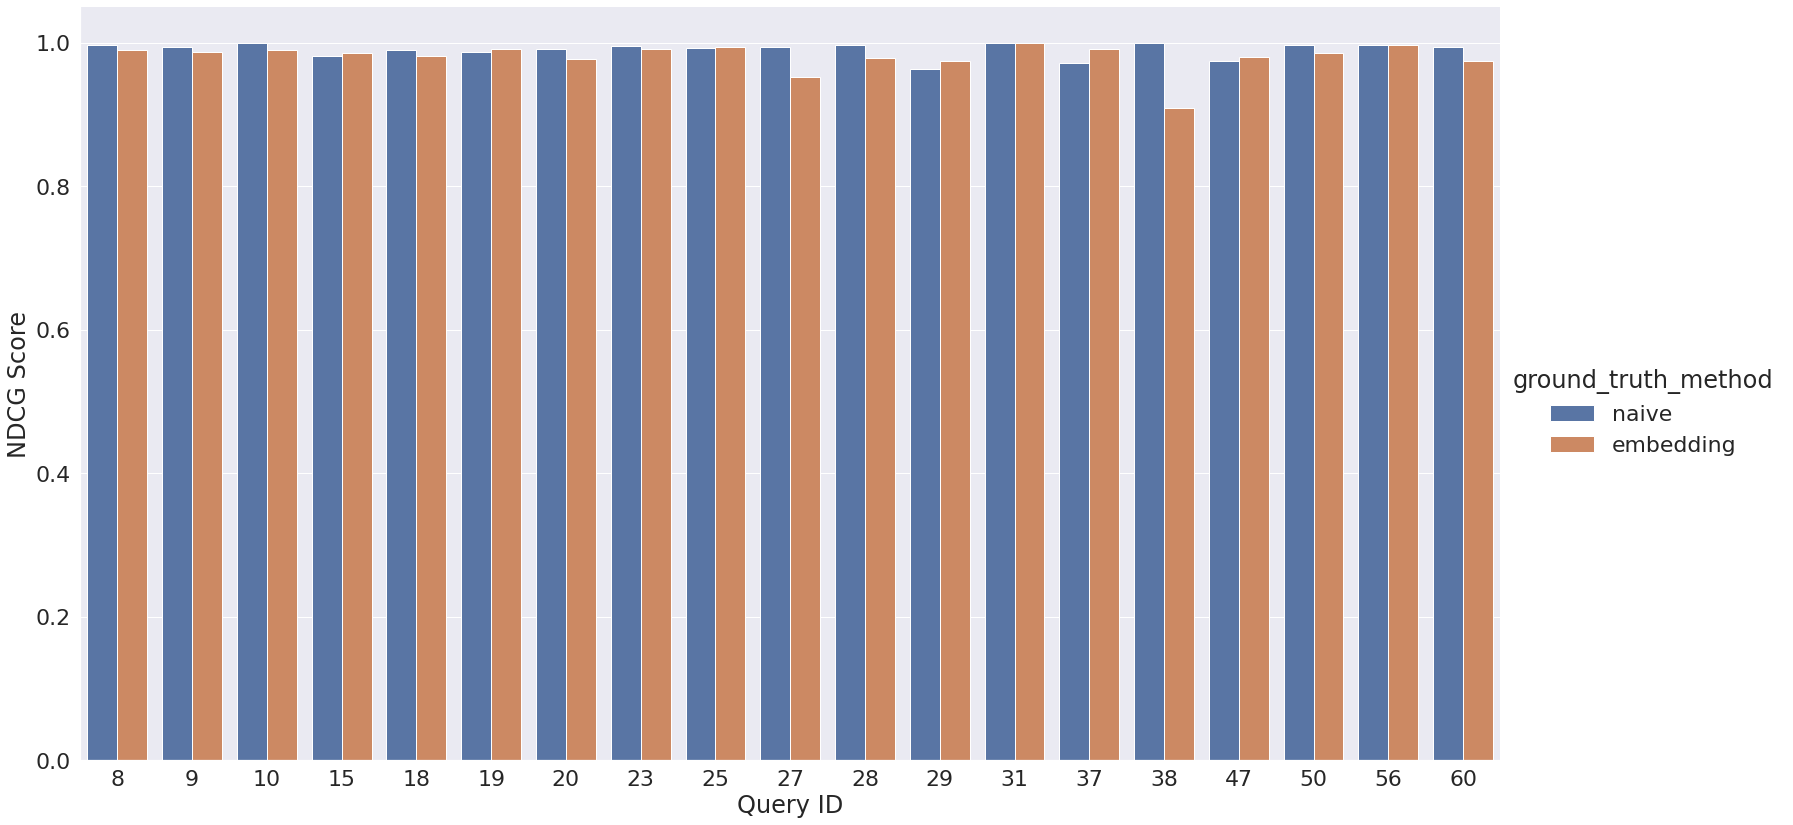

In [35]:
ax = sns.catplot(x="query_id", y="ndcg", kind='bar', hue="ground_truth_method", data=scores_df, height=12, aspect=1.8)
ax.set(xlabel='Query ID', ylabel='NDCG Score')
plt.savefig('figures/ppr_ndcg_per_query.svg')

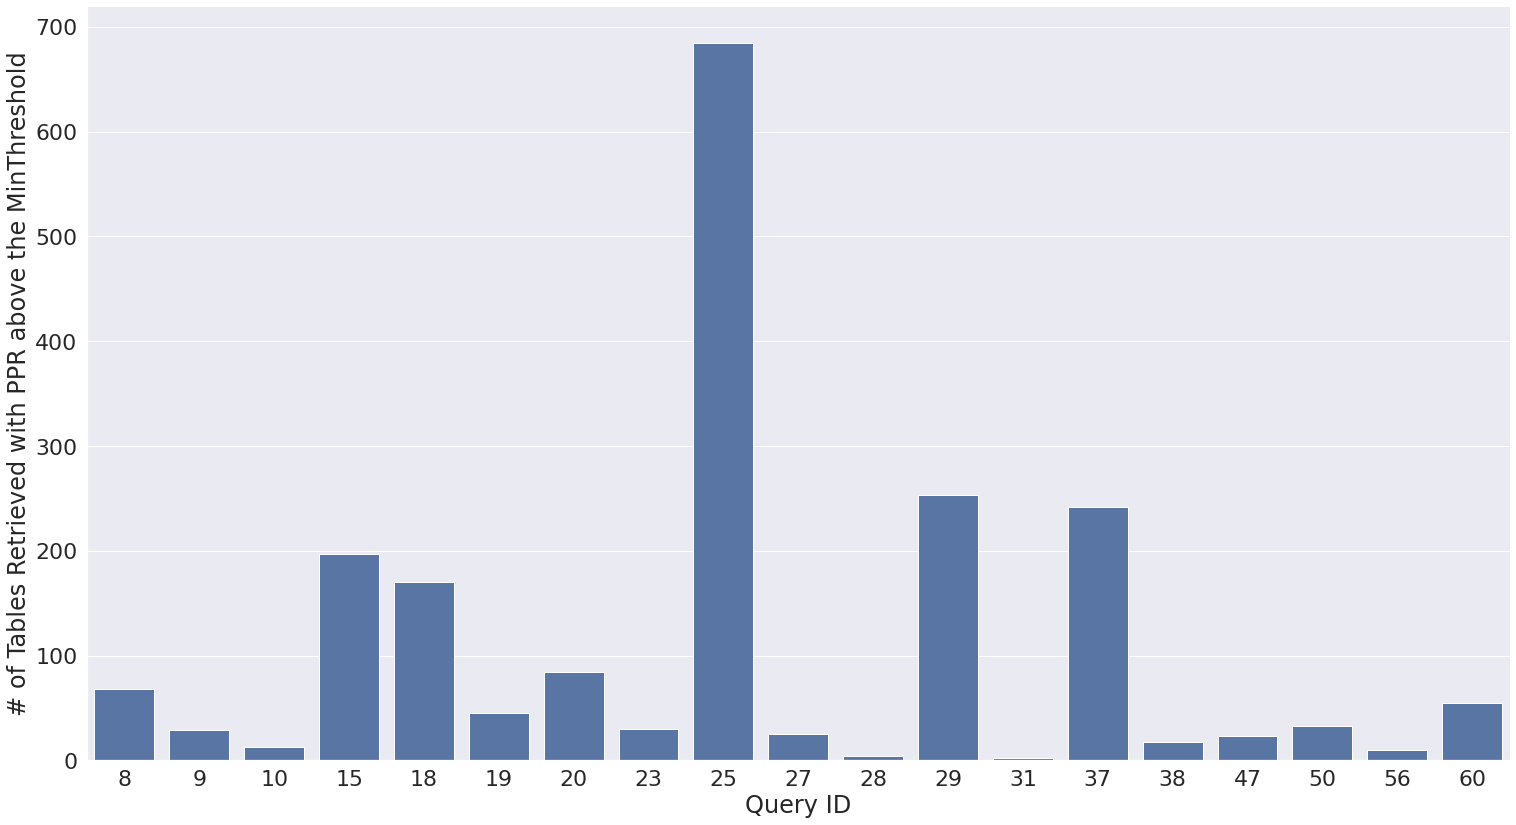

In [41]:
ax = sns.catplot(x="query_id", y="num_tables", kind='bar', hue='ground_truth_method', data=scores_df[scores_df['ground_truth_method'] == 'embedding'], height=12, aspect=1.8, legend=False)
ax.set(xlabel='Query ID', ylabel='# of Tables Retrieved with PPR above the MinThreshold')
plt.savefig('figures/ppr_num_tables_above_threshold.svg')

# PPR Full Dataset Evaluation

In [15]:
q_num=15
naive_path = "../../search/www18_wikitables/full_index/naive/q_" + str(q_num) + "/search_output/filenameToScore.json"
ppr_path = "../../search/www18_wikitables/ppr/q_" + str(q_num) + "/search_output/filenameToScore.json"

with open(naive_path) as f:
    naive_json = json.load(f)

with open(ppr_path) as f:
    ppr_json = json.load(f)

In [16]:
naive_table_to_score = {}
for table_dict in naive_json['scores']:
    naive_table_to_score[table_dict['tableID']] = table_dict['score']

ppr_table_to_score = {}
for table_dict in ppr_json['scores']:
    ppr_table_to_score[table_dict['tableID']] = table_dict['score']

scores_dict = {'tableID': [], 'naive_score': [], 'ppr_score': []}
for tableID in ppr_table_to_score:
    scores_dict['tableID'].append(tableID)
    scores_dict['naive_score'].append(naive_table_to_score[tableID])
    scores_dict['ppr_score'].append(ppr_table_to_score[tableID])

scores_df = pd.DataFrame.from_dict(scores_dict)

# Add ranks
scores_df['naive_rank'] = scores_df['naive_score'].rank(ascending=False).values
scores_df['ppr_rank'] = scores_df['ppr_score'].rank(ascending=False).values
scores_df['rank_delta'] = abs(scores_df['naive_rank'] - scores_df['ppr_rank'])
print("Mean rank delta:", scores_df['rank_delta'].mean())
scores_df

Mean rank delta: 167.0062111801242


,tableID,naive_score,ppr_score,naive_rank,ppr_rank,rank_delta
0,table-0306-942.json,0.775054,10.973622,2.5,1.0,1.5
1,table-0306-941.json,0.775054,9.528936,2.5,2.0,0.5
2,table-0080-649.json,0.623813,4.879997,96.0,3.0,93.0
3,table-0232-986.json,0.630176,4.376952,72.0,4.0,68.0
4,table-1353-353.json,0.630909,4.130001,70.0,5.0,65.0
...,...,...,...,...,...,...
478,table-0287-52.json,0.556830,0.198342,300.0,479.0,179.0
479,table-0086-792.json,0.610258,0.197489,134.0,480.0,346.0
480,table-0112-193.json,0.580225,0.196657,191.0,481.0,290.0
481,table-0661-508.json,0.585300,0.195962,172.0,482.0,310.0


In [17]:
gt_scores = [scores_df['naive_rank'].values]
pred_scores = [scores_df['ppr_rank'].values]
print("NDCG using ranks:", ndcg_score(gt_scores, pred_scores))

NDCG using ranks: 0.8667544158041159


In [18]:
gt_scores = [scores_df['naive_score'].values]
pred_scores = [scores_df['ppr_score'].values]
print("NDCG using scores:", ndcg_score(gt_scores, pred_scores))

NDCG using scores: 0.9822972971096589


In [19]:
k = len(ppr_json['scores'])
print("k: ", k)

naive_tables = [naive_json['scores'][i]['tableID'] for i in range(k)]
ppr_tables = [ppr_json['scores'][i]['tableID'] for i in range(k)]


intersection = set(naive_tables) & set(ppr_tables)
print("Intersection size:", len(intersection))


top_k_table_ranks = []
for i in range(len(naive_json['scores'])):
    table_id = naive_json['scores'][i]['tableID'] 
    if table_id in ppr_tables:
        top_k_table_ranks.append(i)

print("Average Rank:", np.mean(top_k_table_ranks))
print("Minimum Rank:", np.min(top_k_table_ranks))
print("Maximum Rank:", np.max(top_k_table_ranks))

k:  483
Intersection size: 55
Average Rank: 38635.306418219465
Minimum Rank: 0
Maximum Rank: 246162


# Full Data Evaluation

In [2]:
df = pd.read_pickle("query_relevances_cleaned_df.pickle")
df = df[df['relevance']>0]
df

,query_id,column2,table_id,relevance,num_columns,num_rows,num_numeric_columns
379,8,0,table-1610-48,2.0,3,17,0
380,8,0,table-0145-207,2.0,8,49,0
381,8,0,table-0633-54,1.0,2,11,0
384,8,0,table-0176-187,1.0,8,17,0
385,8,0,table-1389-264,1.0,7,15,0
...,...,...,...,...,...,...,...
3078,60,0,table-0221-887,2.0,4,22,1
3079,60,0,table-0609-879,2.0,3,31,1
3080,60,0,table-0831-590,1.0,7,119,2
3084,60,0,table-1376-550,1.0,3,19,1


In [3]:
bad_queries = [8, 10, 17, 37, 46]

In [4]:
queries_dir = "../../search/www18_wikitables/single_column_per_entity/"

q_eval_dict = {"query_id": [], "intersection": [], "num_relevant": [], "num_high_relevant": [], "jaccard": [], "avg_rank": [], "min_rank": [], "max_rank": []}

for inner_dir in tqdm(sorted(os.listdir(queries_dir))):
    filepath = queries_dir + inner_dir + "/search_output/filenameToScore.json"
    with open(filepath) as f:
        data = json.load(f)
    q_id = int(inner_dir.split("_")[1])

    if (q_id not in bad_queries):
    
        df_for_current_query = df[df["query_id"] == q_id]
        
        # Get top-k tables where k equals to the number of groundtruth relevant and highly relevant tables
        top_k_tables = [table["tableID"] for table in data['scores'][:len(df_for_current_query.index)]]
        top_k_tables = [os.path.splitext(x)[0] for x in top_k_tables]

        num_relevant = len(df_for_current_query.index)
        num_high_relevant = len(df_for_current_query[df_for_current_query['relevance'] > 1].index)

        intersection = len(set(df_for_current_query['table_id'].tolist()) & set(top_k_tables))
        union = len(set(df_for_current_query['table_id'].tolist()) | set(top_k_tables))
        jaccard = intersection / union

        top_k_table_ranks = []
        for i in range(len(data['scores'])):
            table_id = os.path.splitext(data['scores'][i]['tableID'])[0] 
            if table_id in df_for_current_query['table_id'].tolist():
                top_k_table_ranks.append(i)
        

        q_eval_dict["query_id"].append(q_id)
        q_eval_dict["intersection"].append(intersection)
        q_eval_dict["num_relevant"].append(num_relevant)
        q_eval_dict["num_high_relevant"].append(num_high_relevant)
        q_eval_dict["jaccard"].append(jaccard)
        q_eval_dict["avg_rank"].append(np.mean(top_k_table_ranks))
        q_eval_dict["min_rank"].append(np.min(top_k_table_ranks))
        q_eval_dict["max_rank"].append(np.max(top_k_table_ranks))
    

100%|██████████| 21/21 [01:03<00:00,  3.04s/it]


In [5]:
q_eval_df = pd.DataFrame.from_dict(q_eval_dict)
q_eval_df

,query_id,intersection,num_relevant,num_high_relevant,jaccard,avg_rank,min_rank,max_rank
0,15,1,30,30,0.016949,36969.566667,4,159064
1,18,0,14,12,0.000000,73556.857143,2442,341000
2,19,0,7,5,0.000000,174467.500000,9624,409981
3,20,0,25,20,0.000000,298301.880000,253537,361021
4,23,0,16,4,0.000000,259022.846154,27897,415333
5,25,0,34,23,0.000000,61359.064516,7093,330200
6,27,0,4,4,0.000000,129.750000,28,270
7,28,0,15,5,0.000000,163651.266667,8008,318539
8,29,2,23,22,0.045455,900.000000,1,9357
9,31,0,10,4,0.000000,191273.700000,96,403687


In [6]:
df[df["query_id"] == 15]

,query_id,column2,table_id,relevance,num_columns,num_rows,num_numeric_columns
729,15,0,table-1413-648,2.0,9,10,4
740,15,0,table-0312-44,2.0,3,11,1
741,15,0,table-0312-31,2.0,3,13,1
742,15,0,table-0312-48,2.0,3,12,1
743,15,0,table-0312-4,2.0,3,16,1
744,15,0,table-0312-70,2.0,3,19,1
745,15,0,table-0311-917,2.0,4,10,1
746,15,0,table-0311-929,2.0,5,10,1
747,15,0,table-0311-822,2.0,4,10,1
748,15,0,table-0080-632,2.0,4,10,1
